# PINN for Poisson equation
# With RAD adaptive sampling with fixed domain sampling interval
$$
\nabla^2 u = f
$$



In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt

# Check device (use MPS if on silicon Mac or CUDA if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# print device
print(f"Using device: {device}")


Using device: mps


In [4]:
# Define the analytical solution
def analytical_solution(x, y):
    return torch.sin(4 * np.pi * (x + y)) + torch.cos(4 * np.pi * x * y)


In [ ]:
# Define the model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 1)
        )

    def forward(self, xy):
        # xy represents the coordinates (x, y) concatenated
        u = self.net(xy)
        return u

def laplacian(u, xy):
    # Compute gradients du/dx and du/dy
    grads = torch.autograd.grad(outputs=u, inputs=xy, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    
    # Compute second derivatives 
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True, retain_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True, retain_graph=True)[0][:, 1]
    
    laplacian = u_xx + u_yy
    return laplacian 

def loss_pinn_adapt(model, xy, x_boundary, u_boundary, f):
    xy = xy.clone().detach().requires_grad_(True)
    x_boundary = x_boundary.clone().detach().requires_grad_(True)
    f = f.clone().detach()
    #predictions
    u = model(xy)
    #compute laplacian
    laplacian_u = laplacian(u, xy)
    physical_loss = torch.mean((laplacian_u - f)**2)
    # boundary condition loss
    u_boundary_pred = model(x_boundary)
    boundary_loss = torch.mean((u_boundary_pred - u_boundary)**2)
    return physical_loss, 10 * boundary_loss

def loss_pinn(model, xy, x_boundary, u_boundary, f):
    xy = xy.clone().detach().requires_grad_(True)
    x_boundary = x_boundary.clone().detach().requires_grad_(True)
    f = f.clone().detach()
    #predictions
    u = model(xy)
    #compute laplacian
    laplacian_u = laplacian(u, xy)
    physical_loss = torch.mean((laplacian_u - f)**2)
    # boundary condition loss
    u_boundary_pred = model(x_boundary)
    boundary_loss = torch.mean((u_boundary_pred - u_boundary)**2)
    return physical_loss + 10 * boundary_loss



def compute_residuals(model, points):
    points = points.clone().detach().requires_grad_(True)
    u = model(points)
    laplacian_u = laplacian(u, points)
    u_analytical = analytical_solution(points[:, 0], points[:, 1])
    f = laplacian(u_analytical, points)
    residuals = torch.abs(laplacian_u - f)
    return residuals.detach()


def compute_pdf(residuals, k=1, c=1):

    # Raise residuals to the power of k
    weighted_residuals = residuals ** k
    
    # Compute the expectation of weighted residuals
    expectation = torch.mean(weighted_residuals)
    
    # Compute the PDF with the added constant c
    pdf = weighted_residuals / expectation + c
    return pdf


def adaptive_sampling(model, n_points, k=1, c=1):
    # Generate candidate points
    n_dense = 50000
    candidates = torch.rand((n_dense, 2), device=device)
    
    # Compute residuals for all candidates
    residuals = compute_residuals(model, candidates)
    
    pdf = compute_pdf(residuals, k, c)
    probabilities = pdf / torch.sum(pdf)
    indices = torch.multinomial(probabilities.flatten(), n_points, replacement=False)
    sampled_points = candidates[indices]
    
    return sampled_points

def adaptive_sampling_RAR_D(model,training_points, n_points, k=2, c=0):
    # Generate candidate points
    n_dense = 50000
    candidates = torch.rand((n_dense, 2), device=device)
    
    # Compute residuals for all candidates
    residuals = compute_residuals(model, candidates)
    
    pdf = compute_pdf(residuals, k, c)
    probabilities = pdf / torch.sum(pdf)
    indices = torch.multinomial(probabilities.flatten(), n_points, replacement=False)
    sampled_points = candidates[indices]
    training_points = torch.cat([training_points, sampled_points], dim=0)
    return training_points

In [6]:
# Problem setup
# Interior points (uniformly sampled within [0 , 1] x [0, 1])
x_interior = torch.rand((1000, 2), device=device)  # Random points in [0, 1] x [0, 1]
# f is the source term i.e. laplactian of u
x_interior = x_interior.requires_grad_(True)
u_analytical = analytical_solution(x_interior[:, 0], x_interior[:, 1])
f = laplacian(u_analytical, x_interior)
x_interior.requires_grad_(False) 

# Boundary points
#x_boundary_x = torch.linspace(0, 1, 250, device=device).unsqueeze(1)
n_boundary_points = 1000
n_boundary_points_per_side = n_boundary_points // 4

x_boundary_x = torch.rand((n_boundary_points_per_side, 1), device=device) * 1.0
x_boundary = torch.cat([
    torch.cat([x_boundary_x, torch.zeros_like(x_boundary_x)], dim=1),
    torch.cat([x_boundary_x, torch.ones_like(x_boundary_x)], dim=1),
    torch.cat([torch.zeros_like(x_boundary_x), x_boundary_x], dim=1),
    torch.cat([torch.ones_like(x_boundary_x), x_boundary_x], dim=1),
], dim=0)

# Boundary condition values using the analytical solution
u_boundary = analytical_solution(x_boundary[:, 0], x_boundary[:, 1]).unsqueeze(1).to(device)




In [7]:
print(u_boundary.shape)
print(x_interior.shape)    


torch.Size([1000, 1])
torch.Size([1000, 2])


In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

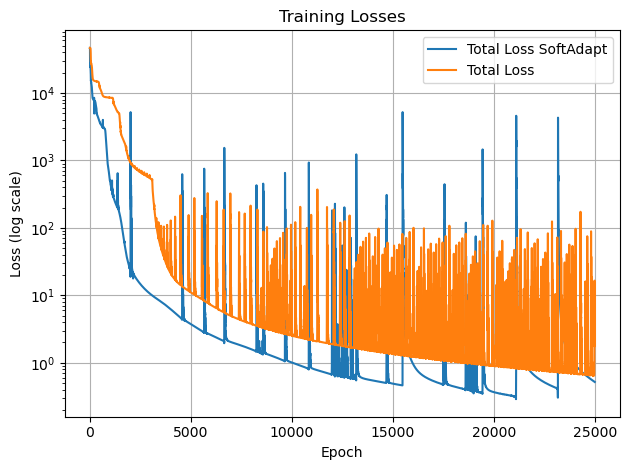

In [ ]:

# Training
num_epochs = 25000
model1 = PINN().to(device)
model2 = PINN().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)


n_interior_points = 1000
physical_losses = []
boundary_losses = []

total_losses_PINN = []
total_losses_PINN_adapt = []
epochs_to_make_updates = 5
softadapt_object = NormalizedSoftAdapt(beta=0.1)

adapt_weights = torch.tensor([1.0, 1.0], device=device)  # Initial equal weights

# Training loop
for epoch in range(num_epochs):
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    physical_loss, boundary_loss = loss_pinn_adapt(model1, x_interior, x_boundary, u_boundary, f)

    physical_losses.append(physical_loss.item())
    boundary_losses.append(boundary_loss.item())
    loss2 = loss_pinn(model2, x_interior, x_boundary, u_boundary, f)

    if epoch % epochs_to_make_updates == 0 and epoch != 0:  
        adapt_weights = softadapt_object.get_component_weights(torch.tensor(physical_losses), 
                                                                 torch.tensor(boundary_losses), 
                                                                 verbose=False,
                                                                 )
        physical_losses = []
        boundary_losses = []

    loss1 = adapt_weights[0] * physical_loss.view(-1) + adapt_weights[1] * boundary_loss.view(-1)
          

    
    loss1.backward()
    loss2.backward()
    optimizer1.step()
    optimizer2.step()

    # Store losses
    total_losses_PINN_adapt.append(loss1.item())
    total_losses_PINN.append(loss2.item())

In [15]:

# Training
num_epochs = 25000
model3 = PINN().to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)



n_interior_points = 1000
total_losses_PINN_rad = []

# Define the resampling interval (in epochs)
resampling_interval = 1000  # Resample every 100 epochs

# Training loop
for epoch in range(num_epochs):
    optimizer3.zero_grad()

    loss3 = loss_pinn(model3, x_interior, x_boundary, u_boundary, f)
    
    loss3.backward()
    optimizer3.step()

    # Store losses
    total_losses_PINN_rad.append(loss3.item())

    
    # Perform resampling at fixed intervals
    if (epoch + 1) % resampling_interval == 0:
        # Resample interior points
        x_interior = adaptive_sampling(model1, n_interior_points)
        x_interior = x_interior.requires_grad_(True)

        
        # Update source term f
        u_analytical = analytical_solution(x_interior[:, 0], x_interior[:, 1])
        f = laplacian(u_analytical, x_interior)
        x_interior.requires_grad_(False)


In [17]:

# Training
num_epochs = 25000
model4 = PINN().to(device)
optimizer4 = optim.Adam(model4.parameters(), lr=0.001)

n_interior_points = 1000
total_losses_PINN_radD = []

# Define the resampling interval (in epochs)
resampling_interval = 1000  # Resample every 100 epochs

# Training loop
for epoch in range(num_epochs):
    optimizer4.zero_grad()

    loss4 = loss_pinn(model4, x_interior, x_boundary, u_boundary, f)
    
    loss4.backward()
    optimizer4.step()

    # Store losses
    total_losses_PINN_radD.append(loss4.item())

    
    # Perform resampling at fixed intervals
    if (epoch + 1) % resampling_interval == 0:
        # Resample interior points
        x_interior = adaptive_sampling(model4, n_interior_points)
        x_interior = x_interior.requires_grad_(True)

        
        # Update source term f
        u_analytical = analytical_solution(x_interior[:, 0], x_interior[:, 1])
        f = laplacian(u_analytical, x_interior)
        x_interior.requires_grad_(False)


''

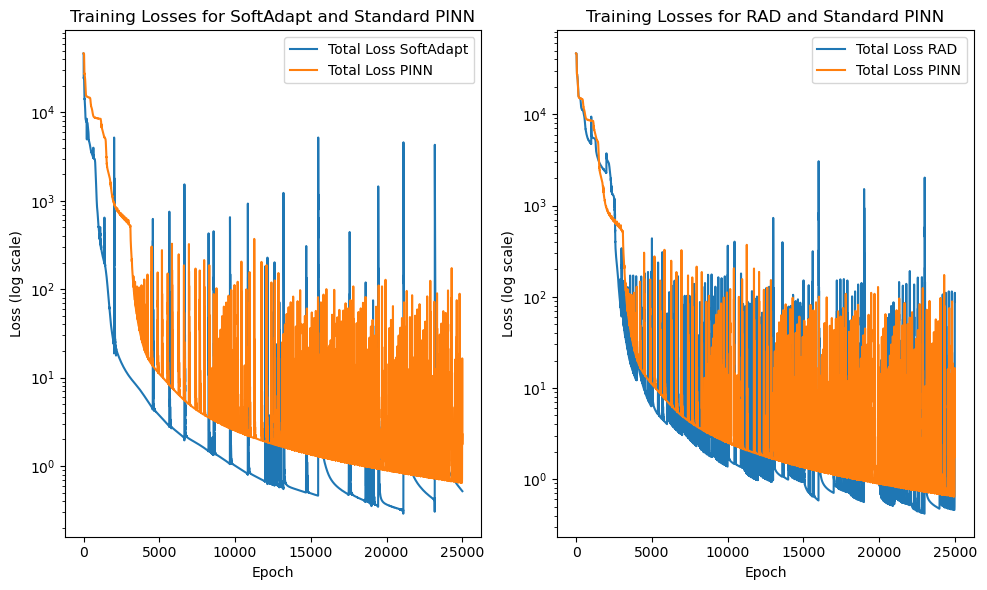

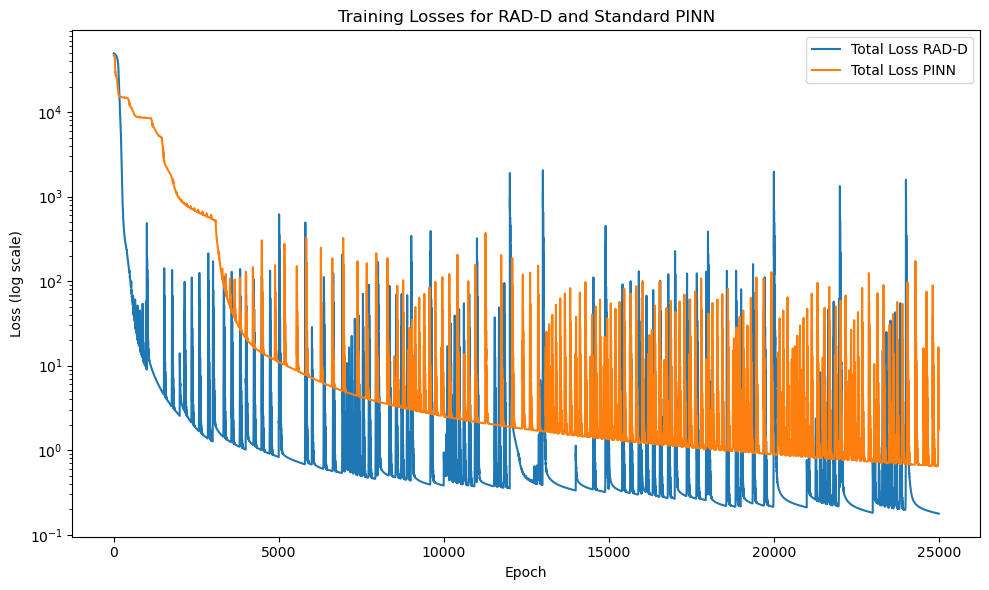

In [ ]:
clear_output(wait=True)

# Create 4 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Plot the training losses
axs[0].semilogy(total_losses_PINN_adapt, label='Total Loss SoftAdapt')
axs[0].semilogy(total_losses_PINN, label='Total Loss PINN')
axs[0].set_title('Training Losses for SoftAdapt and Standard PINN')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss (log scale)')

axs[1].semilogy(total_losses_PINN_rad, label='Total Loss RAD')
axs[1].semilogy(total_losses_PINN, label='Total Loss PINN')
axs[1].set_title('Training Losses for RAD and Standard PINN')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss (log scale)')

# Add legends
axs[0].legend()
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.savefig('figures/train_loss-adapt+RAD.pdf')


plt.figure(figsize=(10, 6))
plt.semilogy(total_losses_PINN_radD, label='Total Loss RAD-D')
plt.semilogy(total_losses_PINN, label='Total Loss PINN')
plt.title('Training Losses for RAD-D and Standard PINN')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.tight_layout()
plt.savefig('figures/train_loss_radD.pdf')
